In [1]:
# Import packages
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset and split into training and testing sets
mnist = loadmat('mnist_49_3000.mat')
X = mnist['x']
y = mnist['y'][0]
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=1000, random_state=42)

In [3]:
# Convert labels
def converter(inp):
    if inp > 0:
        return 1
    else:
        return 0

y_train_mod = [converter(val) for val in y_train]
y_test_mod  = [converter(val) for val in y_test]

In [4]:
# Define the model and regression structures
class LogisticRegression(nn.Module):
    def __init__(self, x_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(x_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

class LogisticRegressionGradientDescent:
    def __init__(self, lr=0.01, lamb=10, num_iter=1000, x_dim=785, fit_intercept=True):
        self.lr = lr
        self.lamb = lamb
        self.num_iter = num_iter
        self.x_dim = x_dim
        self.fit_intercept = fit_intercept
        self.model = LogisticRegression(x_dim)
        
    def __add_intercept(self, x):
        intercept = np.ones((x.shape[0], 1))
        return np.concatenate((intercept, x), axis=1)
    
    def fit(self, x, y):
        if self.fit_intercept:
            x = self.__add_intercept(x)
        
        x = torch.tensor(x).float()
        y = torch.tensor(y).float()
        
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        
        print("Training Error:")
        for epoch in range(self.num_iter):
            # Predict and get weights
            optimizer.zero_grad()
            y_pred = self.model.forward(x)
            theta = self.model.linear.weight
            
            # Calculate loss using the function from the 4.1 in homework document
            regularization_offset = self.lamb * (torch.dot(theta[:, 0], theta[:, 0]))
            loss = criterion(y_pred, y[:, None]) + regularization_offset
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{num_iter}: {float(loss)}")
        
        print(f"Train Error: {float(loss)}")
    
    def predict_confidence(self, x):
        if self.fit_intercept:
            x = self.__add_intercept(x)
        x = torch.tensor(x).float()
        return self.model.forward(x)

    def predict(self, x, threshold):
        preds = self.predict_confidence(x)
        return preds >= threshold
        

In [5]:
# Gradient descent parameters
learning_rates = [0.1, 0.5, 1]
lambs = [0.01, 0.1, 0.5, 0.9, 1]
thresholds = [0.25, 0.4, 0.5, 0.6, 0.75]
num_iter = 1000

max_correct = 0
best_params = []

# Initialize the model, loss function, and optimizer
for lamb in lambs:
    print(f"Lambda: {lamb}")
    for learning_rate in learning_rates:
        print(f"Learning Rate: {learning_rate}")
        model = LogisticRegressionGradientDescent(lr=learning_rate, lamb=lamb, num_iter=num_iter, x_dim=(X_train.shape[1] + 1))
        model.fit(X_train, y_train_mod)
        
        print("Thresholds:")
        for threshold in thresholds:
            preds = model.predict(X_test, threshold)
            predictions = []
            for pred in preds:
                if pred:
                    predictions.append(1)
                else:
                    predictions.append(0)
            
            correct = 0
            total = 0
            for i, val in enumerate(predictions):
                total += 1
                if val == y_test_mod[i]:
                    correct += 1
            if correct > max_correct:
                max_correct = correct
                best_params = [learning_rate, lamb, threshold]
                torch.save(model.model.state_dict(), 'log_reg.ckpt')
            print(f"{threshold}: Correctly predicted: {correct}/{total}")
        print("")
    print("")
print(f"Best Parameters: lr={best_params[0]}, lambda={best_params[1]}, threshold={best_params[2]}")
print(f"Best Performance: {max_correct}/{total}")

Lambda: 0.01
Learning Rate: 0.1
Training Error:
Epoch 0/1000: 0.7196803092956543
Epoch 100/1000: 0.19175724685192108
Epoch 200/1000: 0.14824505150318146
Epoch 300/1000: 0.1292278915643692
Epoch 400/1000: 0.11788052320480347
Epoch 500/1000: 0.11008105427026749
Epoch 600/1000: 0.10426178574562073
Epoch 700/1000: 0.0996793806552887
Epoch 800/1000: 0.09593039005994797
Epoch 900/1000: 0.09277483075857162
Train Error: 0.0900852382183075
Thresholds:
0.25: Correctly predicted: 958/1000
0.4: Correctly predicted: 972/1000
0.5: Correctly predicted: 970/1000
0.6: Correctly predicted: 972/1000
0.75: Correctly predicted: 954/1000

Learning Rate: 0.5
Training Error:
Epoch 0/1000: 0.7057818174362183
Epoch 100/1000: 0.10602858662605286
Epoch 200/1000: 0.0886356309056282
Epoch 300/1000: 0.07959577441215515
Epoch 400/1000: 0.07357361167669296
Epoch 500/1000: 0.06908465921878815
Epoch 600/1000: 0.06551840156316757
Epoch 700/1000: 0.0625658631324768
Epoch 800/1000: 0.060049381107091904
Epoch 900/1000: 0.05

In [6]:
# Train the model again using the best parameters found in the grid sweep above
model = LogisticRegressionGradientDescent(lr=best_params[0], lamb=best_params[1], num_iter=num_iter, x_dim=X_train.shape[1] + 1)
model.model.load_state_dict(torch.load("log_reg.ckpt"))
#%time model.fit(X_train, y_train_mod)

# Generate predictions for the test set
preds = model.predict(X_test, best_params[2])
predictions = []
for pred in preds:
    if pred:
        predictions.append(1)
    else:
        predictions.append(0)

correct = 0
total = 0
incorrect_indices = []
for i, val in enumerate(predictions):
    total += 1
    if val == y_test_mod[i]:
        correct += 1
    else:
        incorrect_indices.append(i)

print(f"Accuracy: {correct}/{total}")

Accuracy: 975/1000


In [7]:
# Separate the incorrectly classified images
incorrect = []
labels = []
for i, pixels in enumerate(X_test):
    if i in incorrect_indices:
        incorrect.append(pixels)
        labels.append(y_test_mod[i])

incorrect_array = np.array(incorrect)
confidences = model.predict_confidence(incorrect_array)

for i in range(len(labels)):
    if labels[i] == 1:
        labels[i] = 4
    else:
        labels[i] = 9

abs_conf = []
for conf in confidences:
    av = abs(float(conf) - 0.5) + 0.5
    abs_conf.append(av)

df = pd.DataFrame({'x': incorrect, 'y': labels, 'confidence': abs_conf})
df_sorted = df.sort_values(by=["confidence"], ascending=False)
df_sorted.reset_index(inplace=True)
df_sorted = df_sorted.head(20)

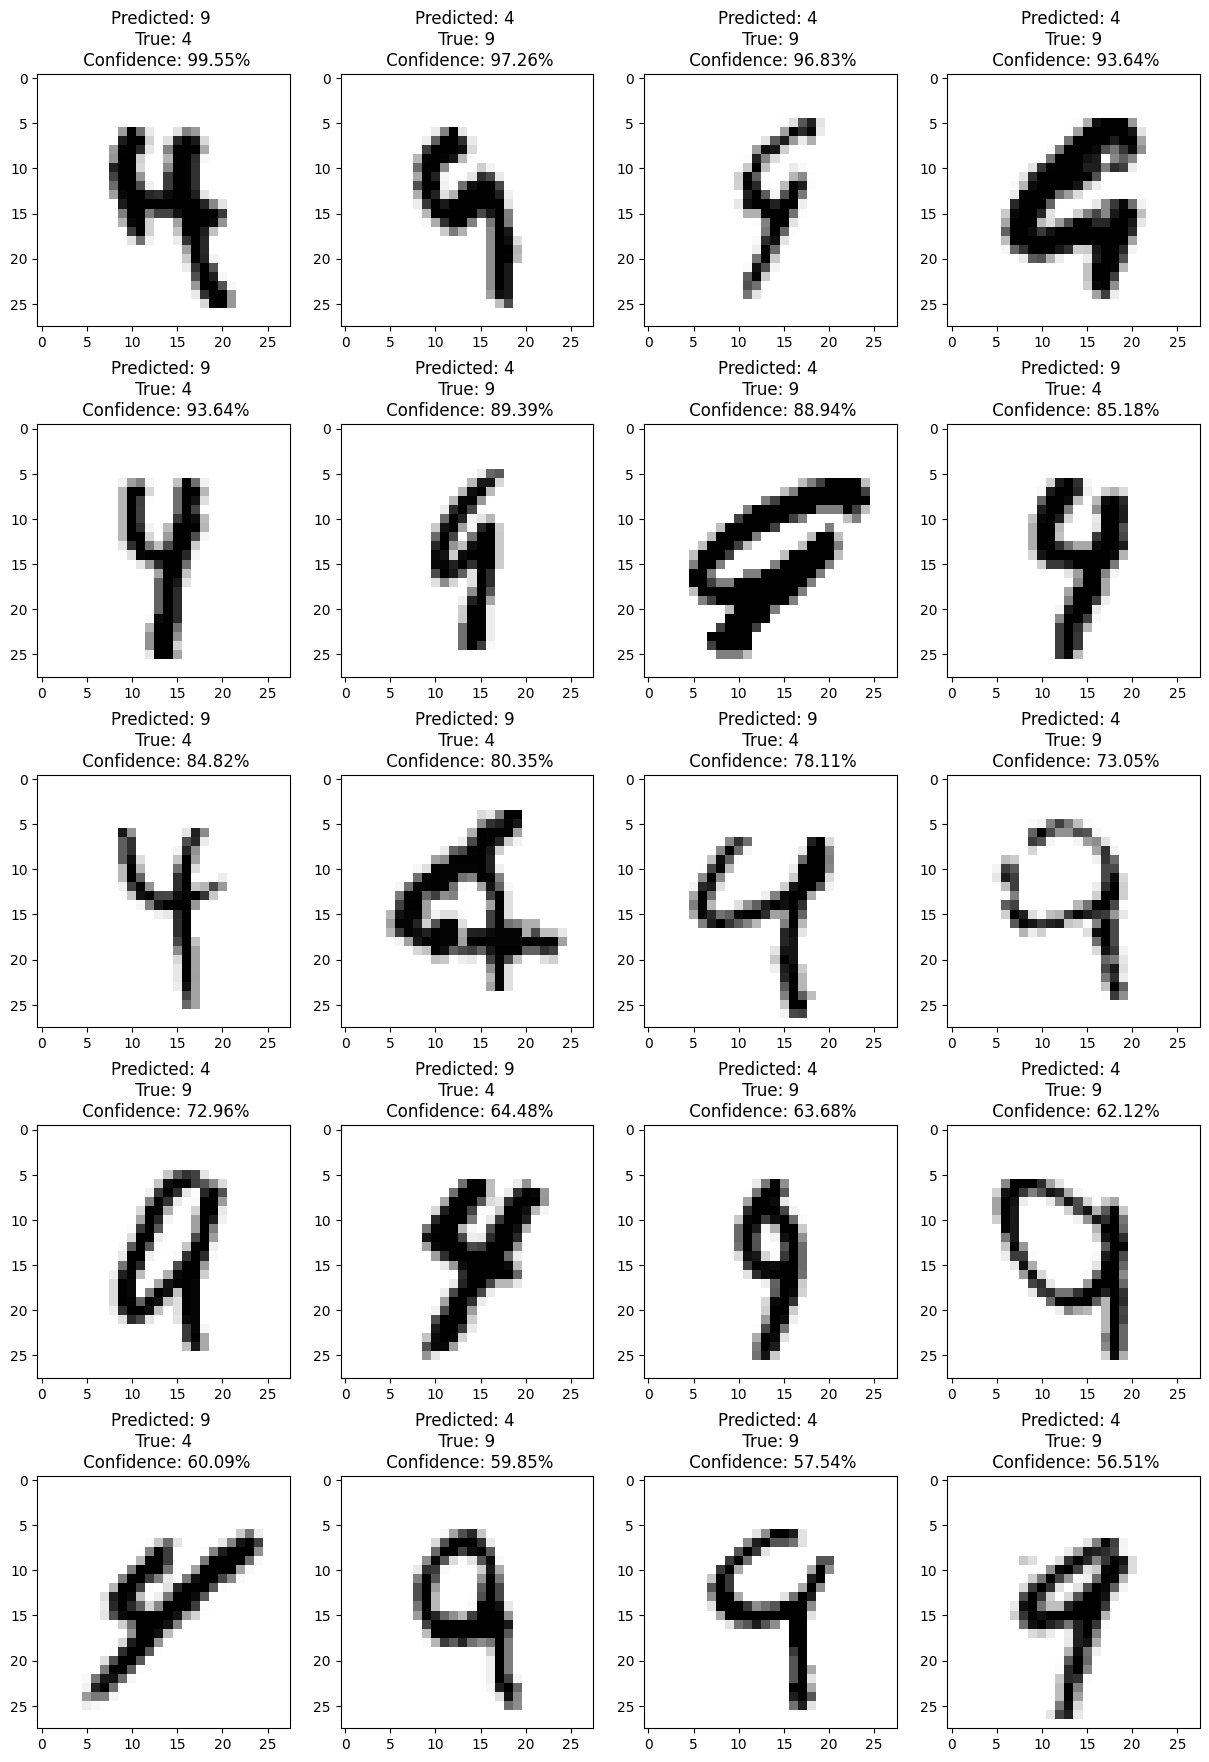

In [14]:
# Display the most confidently predicted incorrect images
plt.figure(figsize=(15, 22))
for index, row in df_sorted.truncate(after=19).iterrows():
    image = row['x'].reshape(28, 28)
    if row['y'] == 4:
        true = 9
    else:
        true = 4
    plt.subplot(5, 4, index + 1)
    plt.imshow(image, cmap=plt.get_cmap('gist_yarg'))
    plt.title(f"Predicted: {row['y']} \n True: {true} \n Confidence: {round(row['confidence'] * 100, 2)}%")